### Visualize Filter Activation of AlexNet in PyTorch  

In [1]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision.models as models
import torchvision.transforms as transforms


In [2]:
def visualize_alexnet_first_layer_filters():
    """Visualizes the filters learned by the first convolutional layer of AlexNet."""

    # Load the pre-trained AlexNet model
    alexnet = models.alexnet(pretrained=True)

    # Access the weights of the first convolutional layer
    first_conv_layer = alexnet.features[0]
    weights = first_conv_layer.weight.data

    # Get the number of filters and channels
    num_filters = weights.size(0)
    num_channels = weights.size(1)

    # Check that it is a color image
    if num_channels != 3:
      print("First layer is not RGB, cannot visualize as color image")
      return

    # Determine the grid size for plotting
    grid_size = int(num_filters ** 0.5)
    if grid_size * grid_size < num_filters:
        grid_size += 1

    # Create a figure and axes for plotting
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    # Iterate over the filters and plot them
    for i in range(num_filters):
        row = i // grid_size
        col = i % grid_size
        if grid_size > 1:
            ax = axes[row, col]
        else:
            ax = axes[col] # if grid_size is 1, axes is 1D

        # Normalize the filter weights for visualization
        filter_weights = weights[i].clone().detach()
        filter_weights = (filter_weights - filter_weights.min()) / (filter_weights.max() - filter_weights.min())

        # Transpose the weights to (height, width, channels) for plotting
        filter_weights = filter_weights.permute(1, 2, 0)

        # Plot the filter
        ax.imshow(filter_weights)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

/drv3/hm3/code/python/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/drv3/hm3/code/python/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


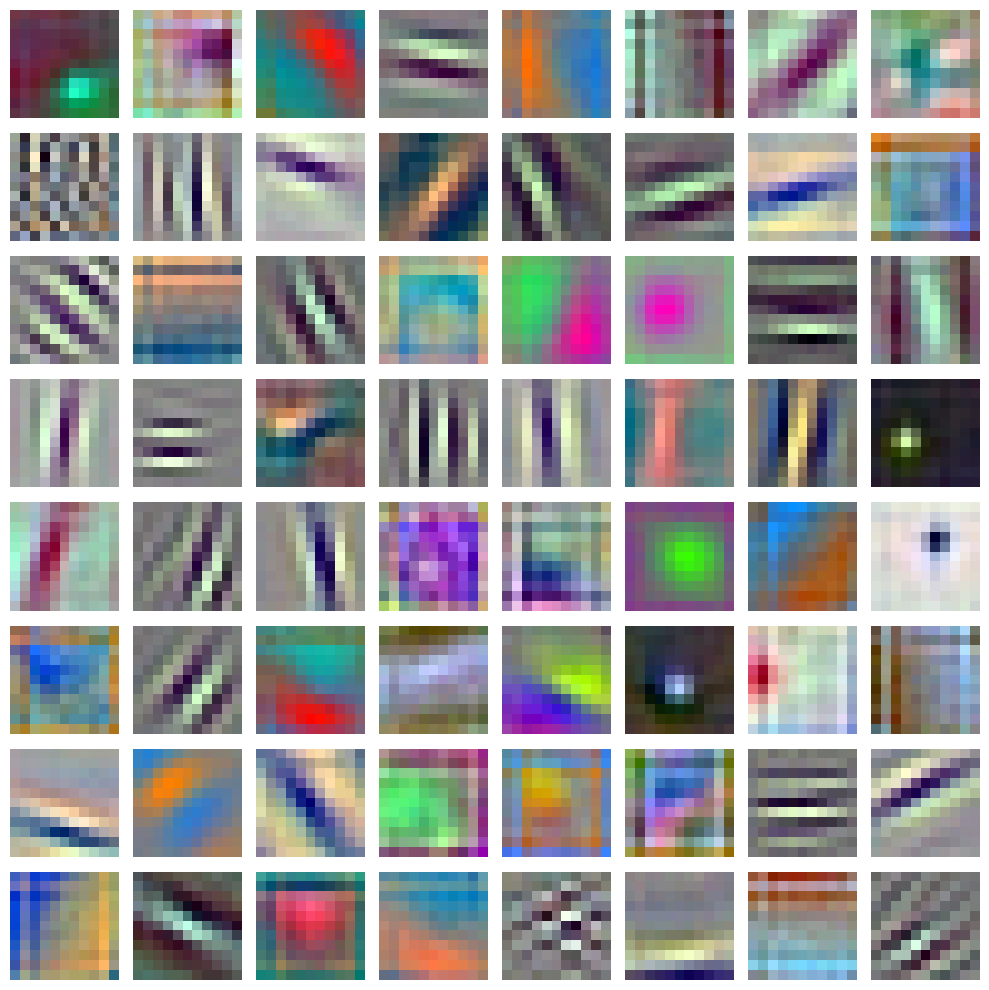

In [3]:
visualize_alexnet_first_layer_filters() 


In [4]:
def visualize_all_alexnet_activations(image_path):
    """Visualizes the activations of all convolutional layers in AlexNet."""

    # Load the pre-trained AlexNet model
    alexnet = models.alexnet(pretrained=True)

    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and preprocess the image
    image = Image.open(image_path)
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)
    alexnet = alexnet.to(device)

    # List to store activations
    activations = []

    # Hook to capture activations
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())

    # Register hooks for each convolutional layer
    hook_handles = []
    for layer in alexnet.features:
        if isinstance(layer, torch.nn.Conv2d):
            hook_handles.append(layer.register_forward_hook(hook_fn))

    # Forward pass
    with torch.no_grad():
        alexnet(input_batch)

    # Remove the hooks after the forward pass
    for handle in hook_handles:
        handle.remove()

    # Visualize activations
    for i, activation in enumerate(activations):
        num_filters = activation.size(1)
        grid_size = int(np.ceil(np.sqrt(num_filters)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.suptitle(f"Layer {i+1} Activations")

        for j in range(num_filters):
            row = j // grid_size
            col = j % grid_size
            if grid_size > 1:
                ax = axes[row, col]
            else:
                ax = axes[col]

            ax.imshow(activation[0, j, :, :], cmap='viridis') #display single activation map
            ax.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # adjust to make space for suptitle
        plt.show()


In [ ]:

image_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/cat_img_from_amazon_s3.jpg"
# image_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/dog.582.jpg"
# image_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/CeciliaMaya.png"
image_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/baby_794.jpg"

visualize_all_alexnet_activations(image_path)

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0